## 텐서후로우 1 버전 이용 DNN과 OLS 사용한
## 사망 기간 예측 Linear Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score, accuracy_score, auc

import statsmodels.api as sm

C:\ProgramData\Anaconda3\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\tf1\lib\site-packages\tensorflow\python\framework

In [2]:
df = pd.read_csv("C:\workspace\project_data\lata\d_final.csv")
df.head()

,id,sex,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,...,tobacco,contact_other_covid,covid_res,icu,DEATH,d_ent,d_sym,d_last,diff_days,age_grp
0,167386,1,2,2,54,2,2,2,2,2,...,2,3,1,2,0,2020-04-06,2020-04-01,2020-06-29,89,3.0
1,0b5948,2,2,1,30,2,2,2,2,2,...,2,3,1,2,0,2020-04-17,2020-04-10,2020-06-29,80,2.0
2,0d01b5,1,2,2,60,2,1,2,2,2,...,2,3,1,2,1,2020-04-13,2020-04-13,2020-04-22,9,4.0
3,1beec8,2,2,1,47,2,1,2,2,2,...,2,3,1,1,1,2020-04-16,2020-04-16,2020-04-29,13,3.0
4,1.75E+56,2,2,2,63,2,2,2,2,2,...,2,3,1,2,0,2020-04-22,2020-04-13,2020-06-29,77,4.0


In [3]:
df['DEATH'].value_counts()

0    88993
1    32402
Name: DEATH, dtype: int64

## 사망기간 예측을 위한 생존자 데이터 제거

In [4]:
df['DEATH'] = df['DEATH'].replace(0, np.nan)
df.dropna(inplace=True)
df['DEATH'].value_counts()

1.0    32402
Name: DEATH, dtype: int64

## 변수 설정

In [5]:
t_train_raw = df[['sex', 'intubed','age_grp','pneumonia',
                  'pregnancy', 'diabetes', 'copd', 'asthma',
                  'inmsupr','hypertension','other_disease',
                  'cardiovascular','obesity', 'renal_chronic', 
                  'tobacco', 'contact_other_covid', 'covid_res', 
                  'icu']]

target_raw = df['diff_days']

In [6]:
# 정규화 적용
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(t_train_raw)
x_train_raw = pd.DataFrame(x_scaled)

## train/test 셋 분리
x_train, x_test, target_train, target_test = train_test_split(x_train_raw, target_raw, test_size=0.2, shuffle = True, random_state = 1004)

In [7]:
print(x_train.shape, target_train.shape)
print(x_test.shape, target_test.shape)

(25921, 18) (25921,)
(6481, 18) (6481,)


## 텐서에 탑재를 위한 차원 변경

- target의 시리즈 데이터를 데이터 프레임으로 변환

In [8]:
target_train1 = target_train.values.reshape(25921, 1)
target_test1 = target_test.values.reshape(6481, 1)

print(x_train.shape, target_train1.shape)
print(x_test.shape, target_test1.shape)

(25921, 18) (25921, 1)
(6481, 18) (6481, 1)


## 텐서후로우 환경 설정
- 텐서후로우 1 버전으로 작성
- multivariable linear regression 모델

In [9]:
x = tf.placeholder(tf.float32, shape=[None, 18])
y = tf.placeholder(tf.float32, shape=[None, 1])

w = tf.Variable(tf.random_normal([18, 1]))
b = tf.Variable(tf.random_normal([1]))

hypothesis = tf.matmul(x,w)+b

loss = tf.reduce_mean(tf.square(hypothesis - y))

train = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for step in range(6001):
        loss_val, hy_val, _ = sess.run([loss, hypothesis, train], 
                 feed_dict={x:x_train, y:target_train1})
        if step % 200 == 0:
            print(step, "loss: ", loss_val, "\naccur: \n", hy_val)
    
    pred = sess.run(hypothesis, feed_dict={x:x_test})
    print("\nTest-set: \n", pred)

0 loss:  204.48393 
accur: 
 [[-1.7966232 ]
 [-0.61089396]
 [-1.7245884 ]
 ...
 [-1.3711643 ]
 [-1.7074814 ]
 [-1.9161592 ]]
200 loss:  61.788086 
accur: 
 [[8.57139 ]
 [8.153793]
 [8.889736]
 ...
 [8.970119]
 [8.370047]
 [8.532091]]
400 loss:  59.10288 
accur: 
 [[ 9.981752]
 [ 9.323647]
 [10.276129]
 ...
 [10.362032]
 [ 9.779137]
 [ 9.985879]]
600 loss:  58.776314 
accur: 
 [[10.233215]
 [ 9.514265]
 [10.472483]
 ...
 [10.596451]
 [10.063694]
 [10.274433]]
800 loss:  58.52392 
accur: 
 [[10.329713]
 [ 9.576885]
 [10.513233]
 ...
 [10.676397]
 [10.195063]
 [10.405701]]
1000 loss:  58.302902 
accur: 
 [[10.400909]
 [ 9.621098]
 [10.531734]
 ...
 [10.731403]
 [10.298904]
 [10.509958]]
1200 loss:  58.108185 
accur: 
 [[10.463947]
 [ 9.661079]
 [10.54538 ]
 ...
 [10.778576]
 [10.39202 ]
 [10.604509]]
1400 loss:  57.936153 
accur: 
 [[10.521452]
 [ 9.698727]
 [10.556623]
 ...
 [10.820513]
 [10.47715 ]
 [10.692078]]
1600 loss:  57.783558 
accur: 
 [[10.574141]
 [ 9.734358]
 [10.56597 ]
 ...

- loss 값은 55 대에서 더 떨어지지 않음

### classification_report

In [11]:
rmse = np.sqrt(mean_squared_error(target_test, pred))
mse = mean_squared_error(target_test, pred)

print("MSE: ", mse, "RMSE: ", rmse)

MSE:  53.7316147914412 RMSE:  7.330185181251644


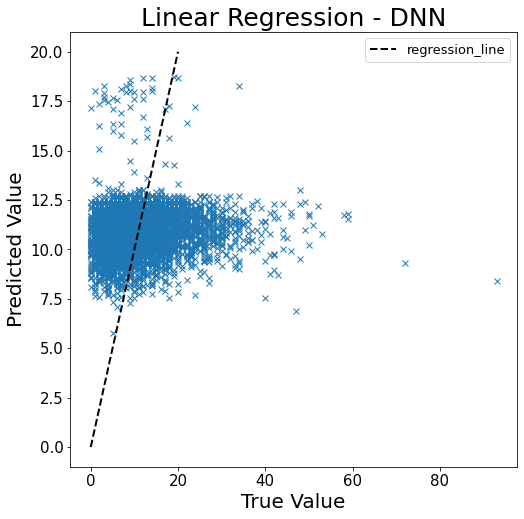

In [25]:
plt.figure(figsize=(8,8))

plt.rc('axes', titlesize=25)   
plt.rc('axes', labelsize=20)  
plt.rc('xtick', labelsize=15)   
plt.rc('ytick', labelsize=15) 
plt.rc('legend', fontsize=13)

plt.plot(target_test, pred,  'x')
plt.plot([0,20],[0,20], 'k--', linewidth=2, label="regression_line")
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Linear Regression - DNN')
plt.legend()

plt.savefig('linReg_DNN.png', dpi=300)

## Pred, True, Error table

In [16]:
pred1 = pred.reshape(6481,)

In [17]:
c = { 'y_true': target_test, 
     'y_pred': pred1.round(), 
     #'error': target_test - pred1.round()}
    }
pred_diff = pd.DataFrame(data=c).reset_index()
pred_diff = pred_diff.drop(['index'], axis=1).reset_index(drop=True)
pred_diff.tail()

,y_true,y_pred
6476,11,11.0
6477,17,11.0
6478,16,12.0
6479,15,10.0
6480,11,12.0


In [27]:
pred_diff.to_csv("C:\workspace\project_data\lata\d_final.csv", encoding='utf-8', index=False, line_terminator='\n')

## ==========================================

## OLS Estimation

In [19]:
# 데이터 로드
x_ols_raw = t_train_raw
target_ols = target_raw

# 정규화 적용
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x_ols_raw)
x_ols = pd.DataFrame(x_scaled)

# 일관성을 위한 코드
# shuffle과 random_seed 값 1004를 적용하여 일관성 있는 순서를 위해 아래 코드가 사용되었음:
x_ols, _, target_ols, _ = train_test_split(x_ols, target_ols, 
                                           test_size=0.01, 
                                           shuffle = True, 
                                           random_state = 1004)

colname = ['sex', 'intubed','age_grp','pneumonia',
            'pregnancy', 'diabetes', 'copd', 'asthma',
            'inmsupr','hypertension','other_disease',
            'cardiovascular','obesity', 'renal_chronic', 
            'tobacco', 'contact_other_covid', 'covid_res', 
            'icu']

x_ols = x_ols.reset_index(drop=True)
x_ols.columns = colname
target_ols = target_ols.reset_index(drop=True)

FD = sm.OLS(endog=target_ols,
            exog=x_ols).fit()
FD.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              diff_days   R-squared (uncentered):                   0.690
Model:                            OLS   Adj. R-squared (uncentered):              0.689
Method:                 Least Squares   F-statistic:                              3958.
Date:                Wed, 23 Sep 2020   Prob (F-statistic):                        0.00
Time:                        19:49:52   Log-Likelihood:                     -1.0976e+05
No. Observations:               32077   AIC:                                  2.196e+05
Df Residuals:                   32059   BIC:                                  2.197e+05
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
sex                     0.3546      0.088      4.013      0.000       0.181       0.528
intubed                -1.9579      0.267     -7.333      0.000      -2.481      -1.435
age_grp                -0.1120      0.212     -0.527      0.598      -0.528       0.304
pneumonia              -0.3643      0.101     -3.597      0.000      -0.563      -0.166
pregnancy              21.9722      0.718     30.595      0.000      20.565      23.380
diabetes                1.0614      0.181      5.866      0.000       0.707       1.416
copd                    0.9882      0.359      2.749      0.006       0.284       1.693
asthma                 -1.2470      0.534     -2.334      0.020      -2.294      -0.200
inmsupr                 0.9972      0.421      2.367      0.018       0.172       1.823
hypertension            0.0381      0.184      0.206      0.836      -0.323       0.399
other_disease           0.3785      0.327      1.158      0.247      -0.262       1.019
cardiovascular          1.0272      0.343      2.994      0.003       0.355       1.700
obesity                 0.0742      0.197      0.376      0.707      -0.312       0.461
renal_chronic           2.1117      0.313      6.744      0.000       1.498       2.725
tobacco                -0.8295      0.283     -2.929      0.003      -1.384      -0.274
contact_other_covid     0.8173      0.139      5.862      0.000       0.544       1.091
covid_res              -2.5513      0.148    -17.232      0.000      -2.842      -2.261
icu                    -3.4075      0.299    -11.387      0.000      -3.994      -2.821
==============================================================================
Omnibus:                    11464.577   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            57474.659
Skew:                           1.664   Prob(JB):                         0.00
Kurtosis:                       8.650   Cond. No.                         38.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 부연설명:
- R-squared (uncentered):	0.690 으로 약 69% 모델 적합도
- x 값이 1 증가할때 마다 해당 coef 만큼 y 값 변동
- 즉 폐렴(pneumonia)가 1 증가 ( 1 : 예 -> 2: 아니오 ) 하면 예상 사망일이 -.3655일 만큼 짧아짐
- 임신 (pregnancy)가 아닐수록 (1 -> 2) 예상 사망일이 21.85일 만큼 길어짐
- 남자 (sex : 2) 일수록 예상 사망일이 0.35일 늘어남 등

### Classification_report

In [20]:
pred2 = FD.predict(x_ols)
rmse1 = np.sqrt(mean_squared_error(target_ols, pred2))
mse1 = mean_squared_error(target_ols, pred2)

print("MSE: ", mse1, "RMSE: ", rmse1)

MSE:  54.924129443341975 RMSE:  7.411081529934884


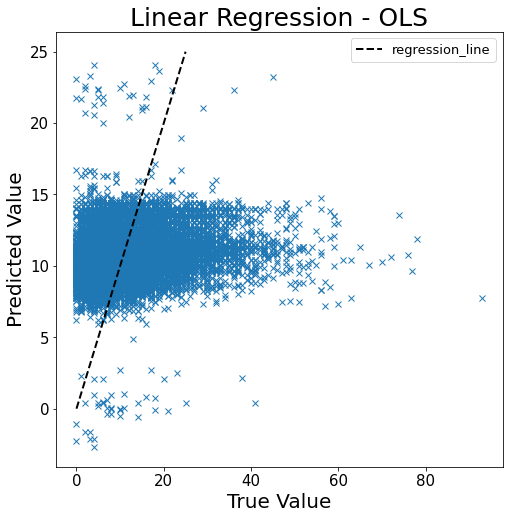

In [26]:
plt.figure(figsize=(8,8))
plt.rc('axes', titlesize=25)   
plt.rc('axes', labelsize=20)  
plt.rc('xtick', labelsize=15)   
plt.rc('ytick', labelsize=15) 
plt.rc('legend', fontsize=13)


plt.plot(target_ols, pred2, 'x')
plt.plot([0,25],[0,25], 'k--', linewidth=2, label="regression_line")
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Linear Regression - OLS')

plt.legend()

plt.savefig('linReg_OLS.png', dpi=300)

## Predicted, True, Error table

In [163]:
d = { 'y_true': target_ols, 
      'y_pred': pred2.round(), 
      #'error': target_ols - pred2.round()}
    }

pred_diff1 = pd.DataFrame(data=d).reset_index()
pred_diff1 = pred_diff1.drop(['index'], axis=1)

In [166]:
pred_diff1.tail()

,y_pred,y_true
32397,12.0,12
32398,10.0,16
32399,10.0,3
32400,11.0,8
32401,12.0,8


In [165]:
pred_diff1.to_csv('A://workspace//AI_project//results//processed//lin_reg_ols.csv', encoding='utf-8', index=False, line_terminator='\n')

- 참고로 OLS는 train/test 를 구분하지 않기 때문에 csv에 모든 예측 결과값이 저장됨
- 총 32402개의 데이터가 입력되었음